## Here I use alredy trained model by google. The last layer of model is skiped and substituted with new-made layer

In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape = IMAGE_SHAPE+(3,))
])


2023-03-11 18:17:49.498729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [7]:
Image.open('goldfish.jpg')

In [8]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)

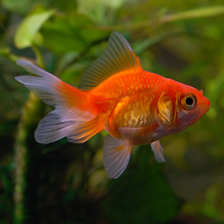

In [9]:
gold_fish

In [10]:
# making an array from a picture

gold_fish = np.array(gold_fish)/255

In [11]:
gold_fish.shape

(224, 224, 3)

In [12]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [13]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 467ms/step


(1, 1001)

In [14]:
result

array([[ 0.22107819,  2.0497682 ,  9.622811  , ..., -1.4619302 ,
        -0.2823095 , -0.2591608 ]], dtype=float32)

In [15]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [38]:
image_labels = []
with open('ImageNetLabels.txt') as f:
    image_labels = f.read().splitlines()

In [39]:
image_labels[:2]

['background', 'tench']

In [40]:
image_labels[predicted_label_index]

'goldfish'

In [41]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, cache_dir = '.', untar = True)

In [42]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [43]:
flowers_images_dict = {
    'roses' : list(data_dir.glob('roses/*')),
    'daisy' : list(data_dir.glob('daisy/*')),
    'dandelion' : list(data_dir.glob('dandelion/*')),
    'sunflower' : list(data_dir.glob('sunflower/*')),
    'tulips' : list(data_dir.glob('tulips/*'))
}

In [44]:
flowers_labels_dict = {
    'roses' : 0,
    'daisy' : 1,
    'dandelion' : 2,
    'sunflower' : 3,
    'tulips' : 4
}

In [45]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/16209331331_343c899d38.jpg'

In [46]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [47]:
img.shape

(243, 500, 3)

In [48]:
cv2.resize(img, IMAGE_SHAPE).shape

(224, 224, 3)

In [49]:
x, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, IMAGE_SHAPE)
        x.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [50]:
x = np.array(x)
y = np.array(y)

In [51]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [52]:
x_train_scaled = x_train/255
x_test_scaled = x_test/255

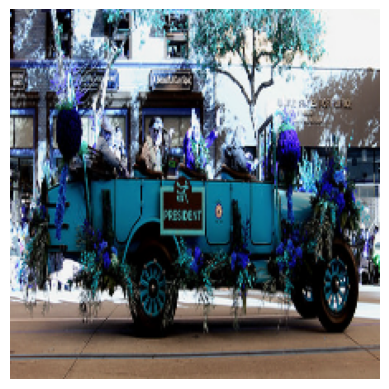

In [53]:
plt.axis('off')
plt.imshow(x[0])

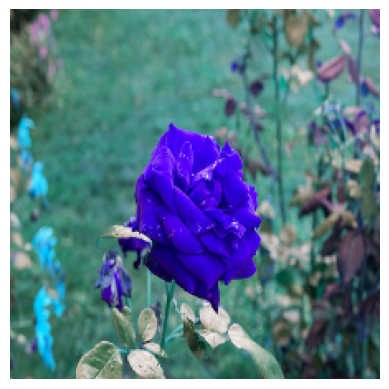

In [58]:
plt.axis('off')
plt.imshow(x[3])

In [59]:
predicted = classifier.predict(np.array([x[0], x[3]]))
predicted = np.argmax(predicted, axis = 1)
predicted

1/1 [==============================] - 0s 49ms/step


array([795, 722])

In [61]:
print(image_labels[795])
print(image_labels[722])

# predictions are incorrect because classifier list contains a thousand of categories. 
# And there is no even a 'flowers' category

shower curtain
pillow


## Retraining the model

In [62]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, 
                                                    input_shape = (224, 224, 3), 
                                                    trainable = False)

In [63]:
num_of_flowers = 5

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_flowers) # out top layer with 5 outputs instead of 1000
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [64]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

In [65]:
model.fit(x_train_scaled, y_train, epochs = 5) 

Epoch 1/5
75/75 [==============================] - 55s 701ms/step - loss: 0.6628 - accuracy: 0.7563
Epoch 2/5
75/75 [==============================] - 54s 724ms/step - loss: 0.3253 - accuracy: 0.8817
Epoch 3/5
75/75 [==============================] - 53s 700ms/step - loss: 0.2571 - accuracy: 0.9141
Epoch 4/5
75/75 [==============================] - 52s 698ms/step - loss: 0.2176 - accuracy: 0.9289
Epoch 5/5
75/75 [==============================] - 52s 698ms/step - loss: 0.1884 - accuracy: 0.9453


In [66]:
model.evaluate(x_test_scaled, y_test)

19/19 [==============================] - 10s 526ms/step - loss: 0.3435 - accuracy: 0.8605


[0.34351009130477905, 0.8605042099952698]

##  On test data I've got an accuracy of 87% after 5 epochs using pretrained model, while with just cnn training it was 10 epochs and 65% of accuracy 
see 'Flowers classification CNN (+data augmentation)' file